## Team Deep-Learners Semantic Segmentation Training Notebook


####Importing and Installing Libraries

In [ ]:
!pip install -U segmentation-models==1.0
!pip install tensorflow==2.2.0
!pip install keras==2.3.1
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [3]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

Using TensorFlow backend.


### Fetching Training Data 

In [4]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,hi;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/26733/2096328/upload/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1617779479&Signature=I6RBPw8xkbtSisVoK8cCsrqCQpSzn%2ByV44gVwcJcwnZX43wrDSHx5Tygp8bOptwKB6snObolmHxx4IJeFG8NBoc9D4KkgQ1j2x2RSIbl8ZFNV9mOrHwNn3QfFfaPLm2Hx8ytlnCNn%2FnWjxMW2%2FRYpnmZdaZQk83179aeWiFWyld56F%2BnS%2BFXWm6AbcvF5t0VecRVQCF8D5Ud8bwx%2B5TR9R3F1EyhL3S8%2FqzVGfuwuFlTaMoGJbL1JuB8Ni4TVoV%2Ff52v7EBuOdT3adFZHPtPDDYWiQUxU4F8mqN5pOA2Yu255kDZyjsCWHMsovHzoSV0SF01la2VjZz%2BzcIhD8x%2BxA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip" -c -O 'train.zip'

--2021-04-04 10:19:04--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/26733/2096328/upload/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1617779479&Signature=I6RBPw8xkbtSisVoK8cCsrqCQpSzn%2ByV44gVwcJcwnZX43wrDSHx5Tygp8bOptwKB6snObolmHxx4IJeFG8NBoc9D4KkgQ1j2x2RSIbl8ZFNV9mOrHwNn3QfFfaPLm2Hx8ytlnCNn%2FnWjxMW2%2FRYpnmZdaZQk83179aeWiFWyld56F%2BnS%2BFXWm6AbcvF5t0VecRVQCF8D5Ud8bwx%2B5TR9R3F1EyhL3S8%2FqzVGfuwuFlTaMoGJbL1JuB8Ni4TVoV%2Ff52v7EBuOdT3adFZHPtPDDYWiQUxU4F8mqN5pOA2Yu255kDZyjsCWHMsovHzoSV0SF01la2VjZz%2BzcIhD8x%2BxA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 614233750 (586M) [application/x-zip-compressed]
Saving to: ‘train.zip’

train.zip          

In [ ]:
!unzip "/content/train.zip" -d "/content/sample_data";

In [6]:
root_dir='/content/sample_data/train/masks'
def return_file_names_df(root_dir):

    root_dir='/content/sample_data/train/masks'
    image=[]
    mask=[]
    json=[]
    for i,j in enumerate(sorted(os.listdir(root_dir))): # creating a list of json files
        if(i%2==0):
            json.append(j)
    for i,j in enumerate(sorted(os.listdir(root_dir))): # creating a list of mask images
        if(i%2==1):
            mask.append(j)
    for i,j in enumerate(sorted(os.listdir('/content/sample_data/train/satellite'))): #creating a list of train images
            image.append(j)        

    data={'image':image,'json':json,'mask':mask} # creating a dataframe of image , json file, mask image
    data_train=pd.DataFrame(data,columns=['image','json','mask'])
    return data_train

In [7]:
data_train = return_file_names_df(root_dir)
data_train.head() # for each image we have its corresponding multi class mask image as given and it's corresponding json file

,image,json,mask
0,TN_628553_13.48331743_80.02359483_18.png,TN_628553_13.48331743_80.02359483_18.json,TN_628553_13.48331743_80.02359483_18.png
1,TN_628557_13.49068585_80.14580484_18.png,TN_628557_13.49068585_80.14580484_18.json,TN_628557_13.49068585_80.14580484_18.png
2,TN_628563_13.47954739_80.12746019_18.png,TN_628563_13.47954739_80.12746019_18.json,TN_628563_13.47954739_80.12746019_18.png
3,TN_628580_13.41880756_80.02593268_18.png,TN_628580_13.41880756_80.02593268_18.json,TN_628580_13.41880756_80.02593268_18.png
4,TN_628585_13.42921065_80.13698256_18.png,TN_628585_13.42921065_80.13698256_18.json,TN_628585_13.42921065_80.13698256_18.png


In [8]:
import json

### Generating Binary Masks From the JSON files Given 

Steps for creating binary masks->

1. Get the list of vertices corresponding to each class from a json file
2. Create a polygon from the list of vertices and fill color according to label_clr dictionary

In [9]:
label_clr = {'Barren Land':0, 'Vegetation':255, 'road_kaccha':0, 'Green Farm':0, 'Dry Farm':0, 'road_pakka':0, 'Water Body':0, 'Building':0, 'Others':0}

In [10]:
def get_poly(file):
    label=[]
    vertexlist=[]
    f = open(file) 
    
    data = json.load(f) 
  
    for j in data['shapes']: 
         label.append((j['label']))
         vertexlist.append([tuple(x) for x in j['points']])
    h=data['imageHeight']
    w=data['imageWidth']     
  
    return w, h, label, vertexlist

In [11]:
import regex as re

In [12]:
def compute_masks(data_df):

    mask=[]
    for i in (range(len(data_train))):
        os.chdir('/content/sample_data/train/masks')
        w,h,l,vl=get_poly(data_df.iloc[i]['json'])
        os.chdir('/content/sample_data/train/output')
        img = Image.new("RGB", (w, h))
        img1 = ImageDraw.Draw(img)
        for j in (range(len(l))):
                img1.polygon(vl[j], fill = label_clr[l[j]])
      
        arr = np.array(img)

        im = Image.fromarray(arr[:,:,0])
        s='/content/sample_data/train/output/'+data_df.iloc[i]['json']
        s=re.sub('json','png',s)
        os.chdir('/content/sample_data')
        im.save(s)
        mask.append(s)
    data_df['mask_image']=mask  

    return data_df

In [14]:
data_train = compute_masks(data_train)
data_train.head()

,image,json,mask,mask_image
0,TN_628553_13.48331743_80.02359483_18.png,TN_628553_13.48331743_80.02359483_18.json,TN_628553_13.48331743_80.02359483_18.png,/content/sample_data/train/output/TN_628553_13...
1,TN_628557_13.49068585_80.14580484_18.png,TN_628557_13.49068585_80.14580484_18.json,TN_628557_13.49068585_80.14580484_18.png,/content/sample_data/train/output/TN_628557_13...
2,TN_628563_13.47954739_80.12746019_18.png,TN_628563_13.47954739_80.12746019_18.json,TN_628563_13.47954739_80.12746019_18.png,/content/sample_data/train/output/TN_628563_13...
3,TN_628580_13.41880756_80.02593268_18.png,TN_628580_13.41880756_80.02593268_18.json,TN_628580_13.41880756_80.02593268_18.png,/content/sample_data/train/output/TN_628580_13...
4,TN_628585_13.42921065_80.13698256_18.png,TN_628585_13.42921065_80.13698256_18.json,TN_628585_13.42921065_80.13698256_18.png,/content/sample_data/train/output/TN_628585_13...


In [15]:
df=data_train.drop(columns=['json','mask']) 

In [16]:
df.head() # Now for each image we have its binary mask 

,image,mask_image
0,TN_628553_13.48331743_80.02359483_18.png,/content/sample_data/train/output/TN_628553_13...
1,TN_628557_13.49068585_80.14580484_18.png,/content/sample_data/train/output/TN_628557_13...
2,TN_628563_13.47954739_80.12746019_18.png,/content/sample_data/train/output/TN_628563_13...
3,TN_628580_13.41880756_80.02593268_18.png,/content/sample_data/train/output/TN_628580_13...
4,TN_628585_13.42921065_80.13698256_18.png,/content/sample_data/train/output/TN_628585_13...


In [17]:
os.chdir('/content/sample_data/train/satellite')

Lets Visualize Some of our Training And Binary Masked Images

In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    

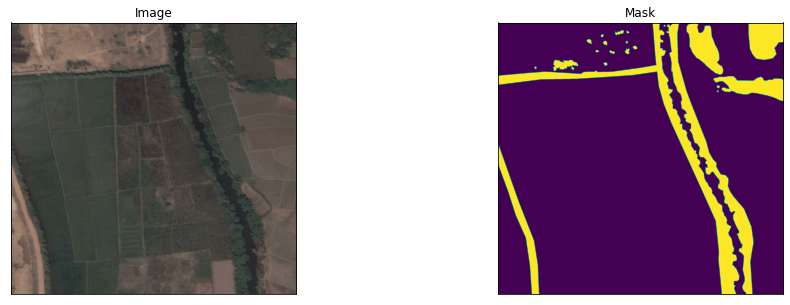

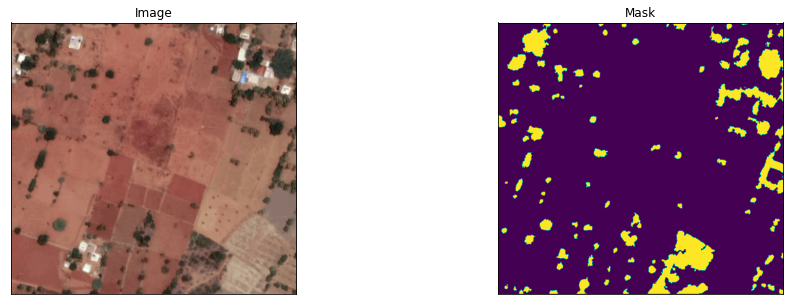

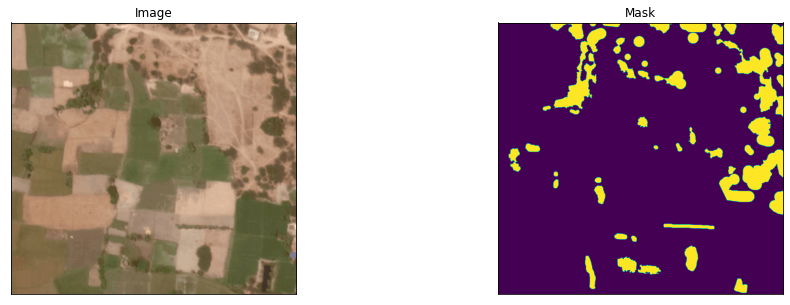

In [ ]:
n = 3
ids = np.random.choice(np.arange(len(df)), size=n)
for i in ids:
    image=cv2.imread(df.iloc[i]['image'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask= cv2.imread(df.iloc[i]['mask_image'])

    visualize(
        Image=image,
        Mask=mask[..., 0].squeeze()
    )

## Creating Dataset

### Generating 512x512 Cropped images from original images and splitting the dataset into train-test in the ratio 70:30.

In [18]:
os.chdir('/content/sample_data/train')

In [19]:
import numpy as np
import cv2
from tqdm import tqdm
import os
import math
import time

def train_test_split(images_path, masks_path, test_split=0.3):
    """
    Splits the dataset into train and test sets and stores then in an ImageDataAugmentation friendly format.   
    Please note:
    > All the images which has less than 5% annotation, in terms of area is removed. In other words, Images that are 95% empty are removed.
    """

    image_filenames = [filename for filename in os.walk(images_path)][0][2]
    test_set_size = int(test_split*len(image_filenames)) 
    
    root_path = os.path.dirname(os.path.dirname(images_path)) + "/"
    train_dir = root_path + "Train/"
    test_dir = root_path + "Test/"
    
    if not os.path.exists(train_dir):
        print("CREATING:", train_dir)
        os.makedirs(train_dir+"Images/samples/")
        os.makedirs(train_dir+"Masks/samples/")
        
    if not os.path.exists(test_dir):
        print("CREATING:", test_dir)
        os.makedirs(test_dir+"Images/samples/")
        os.makedirs(test_dir+"Masks/samples/")
        
    train_image_dir = train_dir+"Images/samples/"
    train_mask_dir = train_dir+"Masks/samples/"
    test_image_dir = test_dir+"Images/samples/"
    test_mask_dir = test_dir+"Masks/samples/"
    
    for n, filename in enumerate(image_filenames):
        if n < test_set_size:
            os.rename(images_path + filename, test_image_dir + filename)
            os.rename(masks_path + filename, test_mask_dir + filename)
        else:
            os.rename(images_path + filename, train_image_dir + filename)
            os.rename(masks_path + filename, train_mask_dir + filename)
            
    print("Train-Test-Split COMPLETED.\nNUMBER OF IMAGES IN TRAIN SET:{}\nNUMBER OF IMAGES IN TEST SET: {}".format(len(image_filenames)-test_set_size, test_set_size))
    print("\nTrain Directory:", train_dir)
    print("Test Directory:", test_dir)

def crop_and_save(images_path, masks_path, new_images_path, new_masks_path, img_width, img_height):
    """
    Imports Images and creates multiple crops and then stores them in the specified folder. Cropping is important to protect spatial information, which otherwise would be lost if we resize the images.

	>images_path (str): Path to the directory containing all the images.
	>masks_path (str): Path to the directory containing all the masks.
	>new_images_path (str): Path to the Directory where the cropped images will be stored.
	>new_masks_path (str): Path to the Directory where the cropped masks will be stored.
	>img_width (int): width of the cropped image.
    >img_height (int): height of the cropped image.
    """
    
    print("Building Dataset.")
    
    num_skipped = 0
    start_time = time.time()
    files = next(os.walk('/content/sample_data/train/satellite/'))[2]
    print('Total number of files =',len(files))
    
    for image_file in tqdm(files, total = len(files)):
       
        image_path = '/content/sample_data/train/satellite/' + image_file
        image = cv2.imread(image_path)

        mask_path = '/content/sample_data/train/output/' + image_file
        mask = cv2.imread(mask_path, 0)

        num_splits = math.floor((image.shape[0]*image.shape[1])/(img_width*img_height))
        counter = 0
        
        for r in range(0, image.shape[0], img_height):
            for c in range(0, image.shape[1], img_width):
                counter += 1
                blank_image = np.zeros((img_height ,img_width, 3), dtype = int)
                blank_mask = np.zeros((img_height ,img_width), dtype = int)
                
                new_image_path = new_images_path + str(counter) + '_' + image_file
                new_mask_path = new_masks_path + str(counter) + '_' + image_file
                
                new_image = np.array(image[r:r+img_height, c:c+img_width,:])
                new_mask = np.array(mask[r:r+img_height, c:c+img_width])
            
                
                blank_image[:new_image.shape[0], :new_image.shape[1], :] += new_image
                blank_mask[:new_image.shape[0], :new_image.shape[1]] += new_mask

                blank_mask[blank_mask>1] = 255
                if np.any(blank_mask):
                    num_black_pixels, num_white_pixels = [ np.sum(blank_mask <255),np.sum(blank_mask == 255)]
                    
                    if num_white_pixels/num_black_pixels < 0.05:
                        num_skipped+=1
                        continue

                    cv2.imwrite(new_image_path, blank_image)
                    cv2.imwrite(new_mask_path, blank_mask)                
                
                

                cv2.imwrite(new_image_path, blank_image)
                cv2.imwrite(new_mask_path, blank_mask)
                
    
    print("EXPORT COMPLETE: {} seconds.\nImages exported to {}\nMasks exported to{}".format(round((time.time()-start_time), 2), new_images_path, new_masks_path))
    print("\n{} Images were skipped.".format(num_skipped))


if __name__ == "__main__":
    root_data_path = "/content/sample_data/train/"
    test_to_train_ratio = 0.3 
    img_width = img_height = 512
    num_channels = 3

    # Path Information
    images_path = root_data_path + "satellite/"
    masks_path = root_data_path + "output/"
    new_images_path = root_data_path + "image_new/"
    new_masks_path = root_data_path + "mask_new/"

    for path in [new_images_path, new_masks_path]:
        if not os.path.exists(path):
            os.mkdir(path)
            print("DIRECTORY CREATED: {}".format(path))
        else:
             print("DIRECTORY ALREADY EXISTS: {}".format(path))

    crop_and_save(images_path, masks_path, new_images_path, new_masks_path, img_width, img_height)
    train_test_split(new_images_path, new_masks_path, test_to_train_ratio)

  0%|          | 0/441 [00:00<?, ?it/s]

DIRECTORY CREATED: /content/sample_data/train/image_new/
DIRECTORY CREATED: /content/sample_data/train/mask_new/
Building Dataset.
Total number of files = 441


100%|██████████| 441/441 [02:26<00:00,  3.00it/s]


EXPORT COMPLETE: 146.96 seconds.
Images exported to /content/sample_data/train/image_new/
Masks exported to/content/sample_data/train/mask_new/

1324 Images were skipped.
CREATING: /content/sample_data/train/Train/
CREATING: /content/sample_data/train/Test/
Train-Test-Split COMPLETED.
NUMBER OF IMAGES IN TRAIN SET:4013
NUMBER OF IMAGES IN TEST SET: 1719

Train Directory: /content/sample_data/train/Train/
Test Directory: /content/sample_data/train/Test/


In [ ]:
os.chdir('/content/sample_data/train/satellite')

### Visualization and DataLoader Function

In [20]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['Barren Land', 'Vegetation', 'road_kaccha', 'Green Farm', 'Dry Farm', 'road_pakka', 'Water Body', 'Building', 'Others']
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids =(images_dir)
        self.images_fps = [os.path.join(images_dir)+image_id for image_id in os.listdir(self.ids)]
        self.masks_fps = [os.path.join(masks_dir)+image_id for image_id in os.listdir(masks_dir)]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls) for cls in classes]
        print(self.class_values)
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == 255) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
 
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(os.listdir(self.ids))
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

### Visualizing Some Random Samples From The DataLoader 

[1]


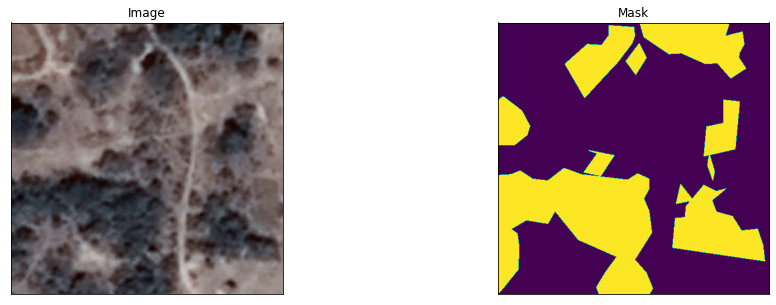

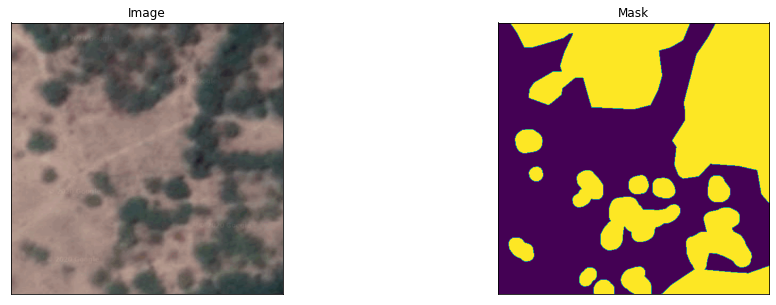

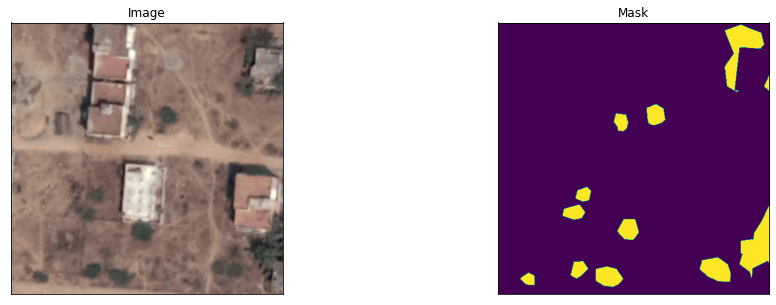

In [ ]:
dataset = Dataset('/content/sample_data/train/Train/Images/samples/', '/content/sample_data/train/Train/Masks/samples/', classes=['Vegetation'])
n = 3
ids = np.random.choice(np.arange(len(dataset)), size=n)
for i in ids:
  image, mask = dataset[i]
  visualize(
        Image=image,
        Mask=mask[..., 0].squeeze()
    )


### Data Augumentation Using Albumentations Library

In [21]:

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.6, border_mode=0),
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=50, sigma=120 * 0.02, alpha_affine=120 * 0.02),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(p=0.5, distort_limit=0.4, shift_limit=0.5)
        ], p=0.8),
        A.RandomRotate90(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.IAASharpen(alpha=(0.1, 0.3), p=0.5),
            A.CLAHE(p=0.8),
           A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
            #GaussianBlur(blur_limit=3, p=0.5),
            A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.3),
        ], p=0.8),
        A.RandomBrightnessContrast(p=0.8),
        A.RandomGamma(p=0.8)]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
              A.RandomBrightness(p=1),
              A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

### Visualizing Some Samples From Training Augumentations Dataset






/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:198: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)


[1]


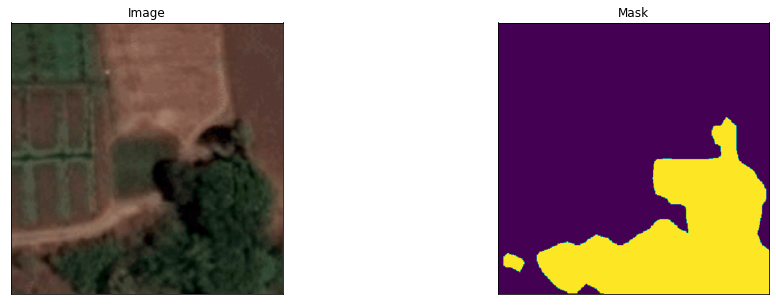

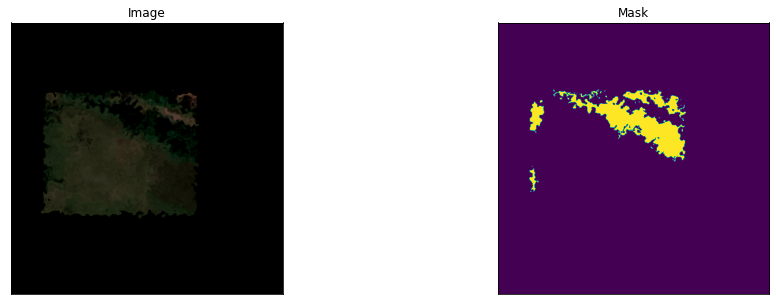

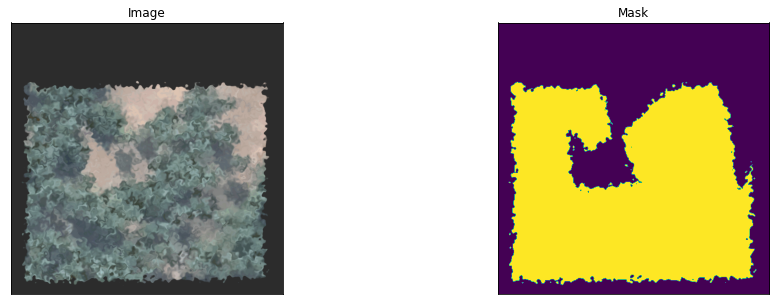

In [ ]:

dataset = Dataset('/content/sample_data/train/Train/Images/samples/', '/content/sample_data/train/Train/Masks/samples/', classes=['Vegetation'],augmentation=get_training_augmentation())

n = 3
ids = np.random.choice(np.arange(len(dataset)), size=n)
for i in ids:
  image, mask = dataset[i]
  visualize(
        Image=image,
        Mask=mask[..., 0].squeeze()
    )

Importing Segmentation Models Library

In [22]:

import segmentation_models as sm


Segmentation Models: using `keras` framework.


Defining the Backbone(Encoder of the Model),Batch Size and Preprocessing Required By the Backbone 

In [ ]:

BATCH_SIZE = 8
CLASSES = ['Vegetation']
LR = 0.0001
EPOCHS = 25
preprocess_input = sm.get_preprocessing('efficientnetb1')

## Creating the Unet Model with The Backbone Defined and with Pretrained-ImageNet weights

In [ ]:
n_classes = 1  
activation = 'sigmoid'

Model 1: UNET+(Efficient-Net-B1 with Decoder Filters =(256,128,64,32,8)) (Training on 512x512 Sized Images)

In [ ]:
model1 = sm.Unet('efficientnetb1', classes=n_classes, activation=activation,decoder_filters=(256, 128, 64, 32, 8))


Model 2 UNET+SEResNext-50 (Training on 512x512 Sized Images)

In [ ]:
model2 = sm.Unet('seresnext50', classes=n_classes, activation=activation)

104685568/104679448 [==============================] - 2s 0us/step


Model 3: UNET+(Efficient-Net-B1 with Transposed Convolution(Training on 512x512 Sized Images)

In [ ]:
model3= sm.Unet('efficientnetb1', classes=n_classes, activation=activation,decoder_block_type='transpose')

Model 4: UNET+ResNet34 (Training on Random Crops of Size (224,224) from the 512x512 Sized Images)

In [ ]:
model4=sm.Unet('resnet34', classes=n_classes, activation=activation)

85524480/85521592 [==============================] - 1s 0us/step


Model 5: UNET+Efficient-Net-B1 (Training on Random Crops of Size (256,256) from the 512x512 Sized Images)

In [ ]:
model5= sm.Unet('efficientnetb1', classes=n_classes, activation=activation)

Defining the Optimizier, Loss Function and  evaluation Metrics

In [ ]:
optim = keras.optimizers.Adam(LR)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim,sm.losses.bce_dice_loss, metrics)
model2.compile(optim,sm.losses.bce_dice_loss, metrics)
model3.compile(optim,sm.losses.bce_dice_loss, metrics)
model4.compile(optim,sm.losses.bce_dice_loss, metrics)
model5.compile(optim,sm.losses.bce_dice_loss, metrics)

Model 1: Dataset Preparation and Fitting

In [ ]:
train_dataset1 = Dataset(
  '/content/sample_data/train/Train/Images/samples/','/content/sample_data/train/Train/Masks/samples/',
  
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(sm.get_preprocessing('efficientnetb1')),
)

# Dataset for validation images
valid_dataset1 = Dataset(
 '/content/sample_data/train/Test/Images/samples/','/content/sample_data/train/Test/Masks/samples/',
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(sm.get_preprocessing('efficientnetb1')),
)

train_dataloader1 = Dataloder(train_dataset1, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader1 = Dataloder(valid_dataset1, batch_size=4, shuffle=False)

# check shapes for errors
assert train_dataloader1[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader1[0][1].shape == (BATCH_SIZE, 512, 512, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving


/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:198: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1727: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


[1]
[1]


In [ ]:
 train_dataloader1[0][0].shape

(8, 512, 512, 3)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/weights/modeleffb1filter.h5', save_weights_only=True, save_best_only=True, mode='max',monitor='val_iou_score',),
    keras.callbacks.ReduceLROnPlateau()]

In [ ]:
history = model1.fit_generator(
    train_dataloader1, 
    steps_per_epoch=len(train_dataloader1), 
    epochs=25, 
    validation_data=valid_dataloader1, 
    callbacks=callbacks

)

Epoch 1/25
501/501 [==============================] - 341s 680ms/step - loss: 1.1034 - iou_score: 0.4929 - f1-score: 0.6486 - val_loss: 0.8816 - val_iou_score: 0.5026 - val_f1-score: 0.6554
Epoch 2/25
501/501 [==============================] - 336s 671ms/step - loss: 0.9127 - iou_score: 0.5708 - f1-score: 0.7165 - val_loss: 0.8448 - val_iou_score: 0.4946 - val_f1-score: 0.6510
Epoch 3/25
501/501 [==============================] - 336s 671ms/step - loss: 0.8293 - iou_score: 0.6037 - f1-score: 0.7438 - val_loss: 0.7179 - val_iou_score: 0.6009 - val_f1-score: 0.7411
Epoch 4/25
501/501 [==============================] - 336s 670ms/step - loss: 0.7755 - iou_score: 0.6244 - f1-score: 0.7601 - val_loss: 0.8002 - val_iou_score: 0.5801 - val_f1-score: 0.7227
Epoch 5/25
501/501 [==============================] - 336s 670ms/step - loss: 0.7374 - iou_score: 0.6404 - f1-score: 0.7727 - val_loss: 0.6492 - val_iou_score: 0.6312 - val_f1-score: 0.7658
Epoch 6/25
501/501 [==============================

KeyboardInterrupt: ignored

Model 2: Dataset Preparation and Fitting

In [ ]:
train_dataset2 = Dataset(
  '/content/sample_data/train/Train/Images/samples/','/content/sample_data/train/Train/Masks/samples/',
  
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(sm.get_preprocessing('seresnext50')),
)

# Dataset for validation images
valid_dataset2 = Dataset(
 '/content/sample_data/train/Test/Images/samples/','/content/sample_data/train/Test/Masks/samples/',
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(sm.get_preprocessing('seresnext50')),
)

train_dataloader2 = Dataloder(train_dataset2, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader2 = Dataloder(valid_dataset2, batch_size=4, shuffle=False)

# check shapes for errors
assert train_dataloader2[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader2[0][1].shape == (BATCH_SIZE, 512, 512, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving


/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:198: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1727: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


[1]
[1]


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/weights/modeleseresnet50.h5', save_weights_only=True, save_best_only=True, mode='max',monitor='val_iou_score',),
    keras.callbacks.ReduceLROnPlateau()]

In [ ]:
history = model2.fit_generator(
    train_dataloader2, 
    steps_per_epoch=len(train_dataloader2), 
    epochs=25, 
    validation_data=valid_dataloader2, 
    callbacks=callbacks

)

Model 3: Only Fitting As Both Model 1 and 3  Require Same Preprocessing And Augumentation,so will use the train_dataloader1 and valid_dataloader1 for Model 3

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/weights/modelefffb1trans.h5', save_weights_only=True, save_best_only=True, mode='max',monitor='val_iou_score',),
    keras.callbacks.ReduceLROnPlateau()]

In [ ]:
history = model3.fit_generator(
    train_dataloader1, 
    steps_per_epoch=len(train_dataloader1), 
    epochs=25, 
    validation_data=valid_dataloader1,
     callbacks=callbacks

)

Model 4: Dataset Preparation and Fitting

In [ ]:

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation4():
    train_transform = [

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.6, border_mode=0),
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=50, sigma=120 * 0.02, alpha_affine=120 * 0.02),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(p=0.5, distort_limit=0.4, shift_limit=0.5)
        ], p=0.8),
        A.RandomRotate90(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.IAASharpen(alpha=(0.1, 0.3), p=0.5),
            A.CLAHE(p=0.8),
           A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
            #GaussianBlur(blur_limit=3, p=0.5),
            A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.3),
        ], p=0.8),
        A.RandomBrightnessContrast(p=0.8),
        A.RandomGamma(p=0.8),
        A.RandomCrop(224,224,always_apply=True)
        ]
    return A.Compose(train_transform)


def get_validation_augmentation4():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
                 A.RandomBrightness(p=1),
                 A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [ ]:
train_dataset4 = Dataset(
  '/content/sample_data/train/Train/Images/samples/','/content/sample_data/train/Train/Masks/samples/',
  
    classes=CLASSES, 
    augmentation=get_training_augmentation4(),
    preprocessing=get_preprocessing(sm.get_preprocessing('resnet34')),
)

# Dataset for validation images
valid_dataset4 = Dataset(
 '/content/sample_data/train/Test/Images/samples/','/content/sample_data/train/Test/Masks/samples/',
    classes=CLASSES, 
    augmentation=get_validation_augmentation4(),
    preprocessing=get_preprocessing(sm.get_preprocessing('resnet34')),
)

train_dataloader4 = Dataloder(train_dataset4, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader4 = Dataloder(valid_dataset4, batch_size=4, shuffle=False)

# check shapes for errors
assert train_dataloader4[0][0].shape == (BATCH_SIZE, 224, 224, 3)
assert train_dataloader4[0][1].shape == (BATCH_SIZE, 224, 224, n_classes)




/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:198: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1727: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


[1]
[1]


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/weights/resnet34-228TT.h5', save_weights_only=True, save_best_only=True, mode='max',monitor='val_iou_score',),
    keras.callbacks.ReduceLROnPlateau()]

In [ ]:
history = model4.fit_generator(
    train_dataloader1, 
    steps_per_epoch=len(train_dataloader4), 
    epochs=25, 
    validation_data=valid_dataloader4,
     callbacks=callbacks

)

Model 5: Dataset Preparation and Fitting

In [ ]:

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation5():
    train_transform = [

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.6, border_mode=0),
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=50, sigma=120 * 0.02, alpha_affine=120 * 0.02),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(p=0.5, distort_limit=0.4, shift_limit=0.5)
        ], p=0.8),
        A.RandomRotate90(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.IAASharpen(alpha=(0.1, 0.3), p=0.5),
            A.CLAHE(p=0.8),
           A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
            #GaussianBlur(blur_limit=3, p=0.5),
            A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.3),
        ], p=0.8),
        A.RandomBrightnessContrast(p=0.8),
        A.RandomGamma(p=0.8),
        A.RandomCrop(256,256,always_apply=True)
        ]
    return A.Compose(train_transform)


def get_validation_augmentation5():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
                A.OneOf(
            [

                A.RandomBrightness(p=1),

            ],
            p=0.9,
        ),


        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [ ]:
train_dataset5 = Dataset(
  '/content/sample_data/train/Train/Images/samples/','/content/sample_data/train/Train/Masks/samples/',
  
    classes=CLASSES, 
    augmentation=get_training_augmentation5(),
    preprocessing=get_preprocessing(sm.get_preprocessing('efficientnetb1')),
)

# Dataset for validation images
valid_dataset5 = Dataset(
 '/content/sample_data/train/Test/Images/samples/','/content/sample_data/train/Test/Masks/samples/',
    classes=CLASSES, 
    augmentation=get_validation_augmentation5(),
    preprocessing=get_preprocessing(sm.get_preprocessing('efficientnetb1')),
)

train_dataloader5 = Dataloder(train_dataset5, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader5 = Dataloder(valid_dataset5, batch_size=4, shuffle=False)

# check shapes for errors
assert train_dataloader5[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader5[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)




/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:198: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1727: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


[1]
[1]


In [ ]:
train_dataloader5[0][0].shape

(8, 256, 256, 3)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/weights/unetb1randomcrop256.h5', save_weights_only=True, save_best_only=True, mode='max',monitor='val_iou_score',),
    keras.callbacks.ReduceLROnPlateau()]

In [ ]:
history = model5.fit_generator(
    train_dataloader5, 
    steps_per_epoch=len(train_dataloader1), 
    epochs=25, 
    validation_data=valid_dataloader5,
     callbacks=callbacks

)

Plotting train and validation losses

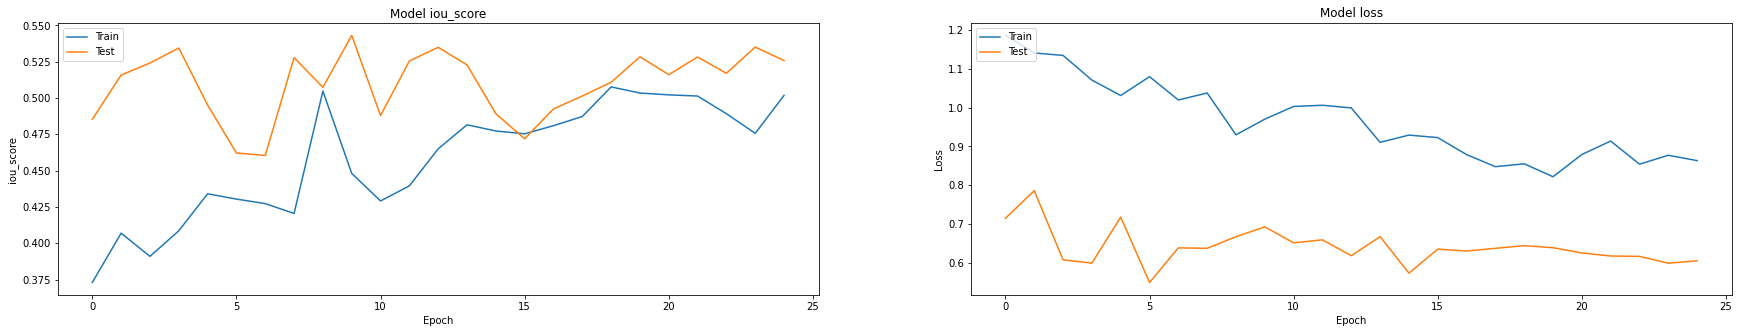

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Visualizing predictions on validation dataset by model1

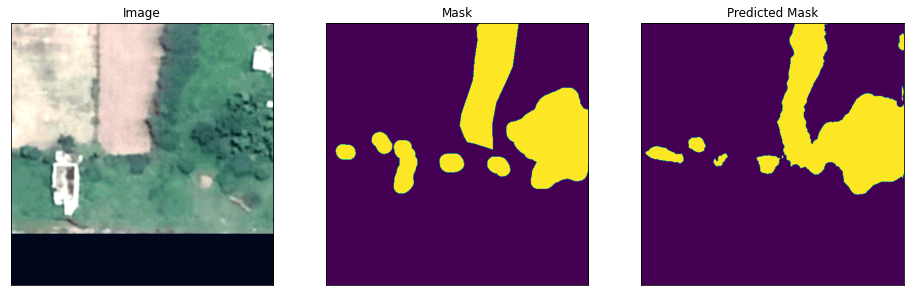

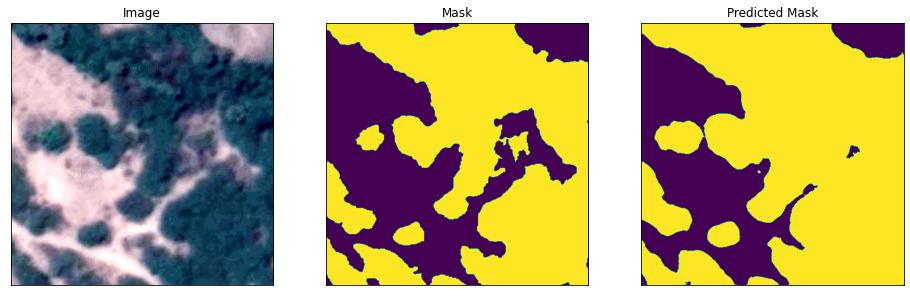

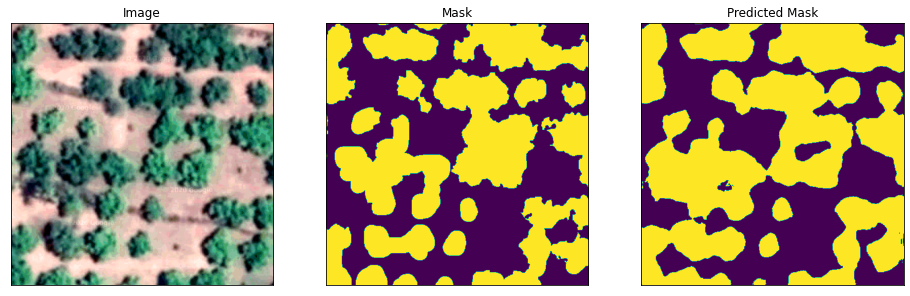

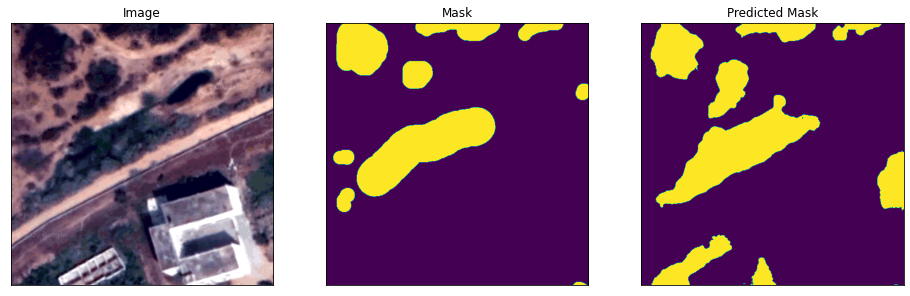

In [39]:
n = 4
ids = np.random.choice(np.arange(len(valid_dataset1)), size=n)

for i in ids:
    
    image, mask = valid_dataset1[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model1.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        mask=mask[..., 0].squeeze(),
        Predicted_Mask=pr_mask[..., 0].squeeze(),
    )